<a href="https://colab.research.google.com/github/akashkatiyar74/Dog_breed/blob/main/dog_breed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np 
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

In [ ]:
df_labels = pd.read_csv("/content/drive/MyDrive/labels.csv")
#store training and testing images
train_file = '/content/drive/MyDrive/train_dogbreed/'
test_file = '/content/drive/MyDrive/test/'

In [ ]:
print("Total number of unique Dog Breeds :",len(df_labels.breed.unique()))

Total number of unique Dog Breeds : 120


In [ ]:
num_breeds = 120
batch_size = 64
encoder = LabelEncoder()

In [ ]:
df_labels['img_file'] = df_labels['id'].apply(lambda x: x + ".jpg")

In [ ]:
#create a numpy array of the shape
train_x = np.zeros((len(df_labels), 224, 224, 3), dtype='float32')
for i, img_id in enumerate(df_labels['img_file']):
  img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((224,224)))
#scale array into the range of -1 to 1.
  img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  train_x[i] = img_array

In [ ]:
train_y = encoder.fit_transform(df_labels["breed"].values)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42)

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
 
train_generator = train_datagen.flow(x_train, 
                                     y_train, 
                                     batch_size=batch_size)
 

test_datagen = ImageDataGenerator()
 
test_generator = test_datagen.flow(x_test, 
                                     y_test, 
                                     batch_size=batch_size)

In [ ]:
resnet = ResNet50V2(input_shape = [224,224,3], weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = False
 
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
predictions = Dense(num_breeds, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=predictions)
#model.summary()

In [ ]:
epochs = 20
learning_rate = 1e-3
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
 
hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,
                 validation_data= test_generator,
                 validation_steps= x_test.shape[0] // batch_size)
 
model.save("model")

Epoch 1/20
64/64 [==============================] - 848s 13s/step - loss: 2.2624 - accuracy: 0.4423 - val_loss: 0.8186 - val_accuracy: 0.7588
Epoch 2/20
64/64 [==============================] - 818s 13s/step - loss: 1.2663 - accuracy: 0.6207 - val_loss: 0.6880 - val_accuracy: 0.7744
Epoch 3/20
64/64 [==============================] - 744s 12s/step - loss: 1.0883 - accuracy: 0.6742 - val_loss: 0.6957 - val_accuracy: 0.7832
Epoch 4/20
64/64 [==============================] - 741s 12s/step - loss: 1.0537 - accuracy: 0.6860 - val_loss: 0.6720 - val_accuracy: 0.7900
Epoch 5/20
64/64 [==============================] - 742s 12s/step - loss: 0.9688 - accuracy: 0.7169 - val_loss: 0.6554 - val_accuracy: 0.7881
Epoch 6/20
64/64 [==============================] - 744s 12s/step - loss: 0.9208 - accuracy: 0.7277 - val_loss: 0.6660 - val_accuracy: 0.8037
Epoch 7/20
64/64 [==============================] - 739s 12s/step - loss: 0.8624 - accuracy: 0.7333 - val_loss: 0.6842 - val_accuracy: 0.7959
Epoch 

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest Accuracy: ", test_acc)

17/17 - 150s - loss: 0.7218 - accuracy: 0.8097 - 150s/epoch - 9s/step

Test Accuracy:  0.809661865234375


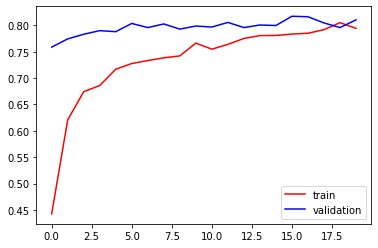

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'],color='red',label='train')
plt.plot(hist.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step


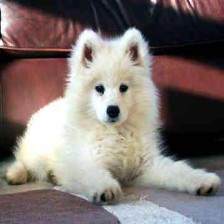

Predicted Breed for this Dog is : pomeranian


In [ ]:
from google.colab.patches import cv2_imshow
model = load_model("model")
 
pred_img_path = '/content/drive/MyDrive/test/002c58d413a521ae8d1a5daeb35fc803.jpg'
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((224,224)))
#scale array into the range of -1 to 1.
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))
 
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((224,224)))) 
 
#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)